## Notebook 10.4

Estimating volatility (variance) of a dataset by fitting data to a series of normal distributions each with a separate mean and variance parameter. This example is an implementation of the model from pymc3 [Case study 2](https://docs.pymc.io/notebooks/getting_started.html#Case-study-1:-Stochastic-volatility). 

In [1]:
# pip install pymc3

In [5]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
import pymc3 as pm
import numpy as np
import pandas as pd
import toyplot
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

### pymc3 case study I: stochastic volatility

The example from the pymc3 tutorial was examining stock prices for a daily stock over a long time period, where they found there was increased volatility around the time of the financial collapse in 2007. Here we will simulate data to have a similar pattern, with low volatility (data drawn from a normal distribution with low stdev) before and after a period of high volatility. 

The model in the example uses a slightly more complicated model, which I've simplified here. 

In [62]:
# simulate data with different volatilities
np.random.seed(123)
returns = pd.DataFrame({
    "returns": np.concatenate([
        np.random.normal(0, 0.2, 50),
        np.random.normal(0, 0.8, 50),
        np.random.normal(0, 0.3, 50),
        ])})
returns.head()

returns
0 -0.217126
1  0.199469
2  0.056596
3 -0.301259
4 -0.115720

### Fit a model

In [69]:
nsize = len(returns)

In [70]:
with pm.Model() as sp500_model:
    
    # draw steps from a halfnormal distribution
    nu = pm.Exponential('nu', 1./10)
    sigma = pm.HalfNormal('sigma', sd=1)

    # random walk: s draws nsize random values for next step in walk
    s = pm.GaussianRandomWalk(
        's', 
        sigma**-2, 
        shape=nsize)
    
    # deterministic = volatility is completely explained by s
    volatility = pm.Deterministic('volatility', pm.math.exp(-2*s))

    # expected distribution is StudentT with 
    # volaitility as scale factor describing precision of normally dist moves
    # nu as degrees of freedom 
    r = pm.StudentT('r', nu, lam=1./volatility, observed=returns.returns)

In [71]:
with sp500_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [01:16<00:00, 72.06it/s]


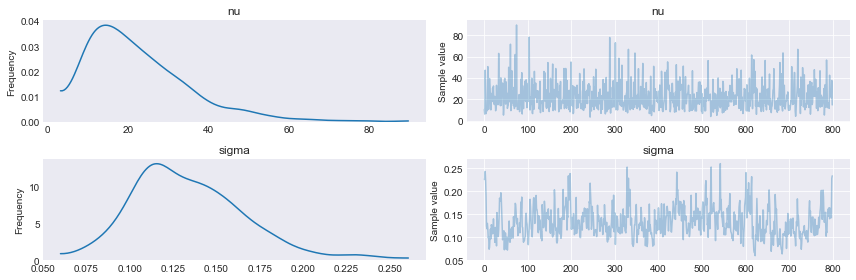

In [72]:
pm.traceplot(trace[1000::5], [nu, sigma]);

In [73]:
# plot inferred volatility along with the data
canvas = toyplot.Canvas(width=500, height=325)
axes = canvas.cartesian(ylabel="volatility", xlabel="time")
axes.plot(returns);
axes.plot(
    1 / np.exp(trace['s', 1000::5].T),
    color='red',
    opacity=0.01);
#canvas.autorender(autoformat='png')

<path d="M 50.0 183.07280327050213 L 52.666666666666664 161.59263562214005 L 55.333333333333336 168.95936545936553 L 58.0 187.41079631666145 L 60.666666666666671 177.84418004652147 L 63.333333333333336 154.84748544035438 L 66.0 196.90203074308749 L 68.666666666666671 176.30056400757704 L 71.333333333333343 158.82286029346551 L 74.0 180.81555301787114 L 76.666666666666657 178.87835321305602 L 79.333333333333329 172.85417265604818 L 82.0 156.49792903498465 L 84.666666666666657 178.4660266520371 L 87.333333333333329 176.45596269866297 L 90.0 176.35664868711126 L 92.666666666666657 149.12940993934552 L 95.333333333333343 149.32682756940801 L 98.0 161.5234564021045 L 100.66666666666667 167.89505988615545 L 103.33333333333334 164.27358184203123 L 106.0 156.50471034901682 L 108.66666666666666 181.52806204365567 L 111.33333333333334 159.7520683184496 L 114.0 184.80783982620403 L 116.66666666666667 178.45416246907311 L 119.33333333333334 162.52321555634674 L 122.0 186.61042128303498 L 124.66666666666666 173.32193370468354 L 127.33333333333333 180.76414123452091 L 130.0 174.51352078095351 L 132.66666666666666 200.73725783930718 L 135.33333333333331 190.14600063982661 L 138.0 179.09481848708899 L 140.66666666666666 162.31328667057505 L 143.33333333333331 173.66808458057463 L 146.0 171.84816239430697 L 148.66666666666666 164.7803862361848 L 151.33333333333334 180.94750794477193 L 154.0 168.9526746066314 L 156.66666666666669 180.18265024306032 L 159.33333333333331 189.6936681682767 L 162.0 175.90856618753199 L 164.66666666666669 165.9602812675993 L 167.33333333333334 168.38589559138336 L 170.0 171.99950919225134 L 172.66666666666669 147.20684391119778 L 175.33333333333334 167.61945718312938 L 178.0 161.78454080748568 L 180.66666666666666 148.79721882532323 L 183.33333333333334 225.25723040923594 L 186.0 214.72648083724911 L 188.66666666666666 99.951131719225998 L 191.33333333333334 204.79679670143094 L 194.0 170.65310674179301 L 196.66666666666666 127.76930012234116 L 199.33333333333334 135.13676588283192 L 202.0 99.490217218317383 L 204.66666666666666 110.18369127393937 L 207.33333333333334 127.76613631274675 L 210.0 203.75096879277356 L 212.66666666666666 139.09022324291391 L 215.33333333333334 158.91410596687359 L 218.0 226.58462874010593 L 220.66666666666666 113.41534759504941 L 223.33333333333334 138.57981366230914 L 226.0 170.00109003703662 L 228.66666666666666 181.49232366129976 L 231.33333333333334 221.30622922224526 L 234.0 163.64734249046424 L 236.66666666666666 152.55486685851207 L 239.33333333333334 206.16181874567093 L 242.0 123.93776010234282 L 244.66666666666666 217.13603418084054 L 247.33333333333331 259.45326787478399 L 250.0 128.98981165231709 L 252.66666666666669 188.51595424955329 L 255.33333333333334 177.0761040386148 L 258.0 206.42423407450616 L 260.66666666666663 238.12186156007488 L 263.33333333333331 120.10022883276508 L 266.0 200.29266409514358 L 268.66666666666663 103.36488777245769 L 271.33333333333331 138.57685810442607 L 274.0 184.86096769890921 L 276.66666666666669 216.66989390659464 L 279.33333333333331 202.09083169303054 L 282.0 221.89287188107187 L 284.66666666666669 85.786179723044086 L 287.33333333333331 165.09447455197008 L 290.0 124.43268645024884 L 292.66666666666669 224.15450969271976 L 295.33333333333331 164.40999286459419 L 298.0 123.2918878735409 L 300.66666666666669 185.69636774140531 L 303.33333333333331 129.34507407339026 L 306.0 216.61484757027648 L 308.66666666666669 228.11934237537753 L 311.33333333333331 156.22761588607841 L 314.0 187.51815739213643 L 316.66666666666669 161.94596846460024 L 319.33333333333331 202.47221939785319 L 322.0 160.85993479535992 L 324.66666666666669 131.6859746472179 L 327.33333333333331 172.25843406550774 L 330.0 171.3493869865128 L 332.66666666666669 169.10017170254383 L 335.33333333333331 200.67924587766984 L 338.0 165.2857148111076 L 340.66666666666669 196.71058768341317 L 343.33333333333331 178.49301793768763 L 346.0 152.65233981754423 L 348.66666666666669 183